In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

**Data and acquisition scheme**

In [3]:
data_path = '/Users/weiwenhua/anaconda3/envs/deepNODDIEnv/lib/python3.10/site-packages/dmipy/data/hcp/100206/data.nii.gz'
data_100206 = nib.load(data_path).get_fdata()

In [4]:
data_100206.shape

(145, 174, 145, 288)

In [5]:
data_100206_slice = np.expand_dims(data_100206[:, 86, :, :], axis=1)

In [6]:
data_100206_slice.shape

(145, 1, 145, 288)

In [7]:
def get_acquisition_scheme():
    bvals = np.loadtxt(
        '/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ivim/data/bvals'
    ) * 1e6
    gradient_directions = np.loadtxt(
        '/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ivim/data/bvecs'
    ).T

    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [8]:
def get_scheme_data():
    "Returns Wu-Minn HCP data subject 100206."
    # data_path = '/Users/weiwenhua/anaconda3/envs/deepNODDIEnv/lib/python3.10/site-packages/dmipy/data/hcp/100206/data.nii.gz'
    try:
        # data = nib.load(data_path).get_data()
        data = data_100206_slice
    except IOError:
        msg = "The example HCP data has not been downloaded yet. "
        msg += "Please follow our HCP tutorial where you can use your own AWS "
        msg += "credentials to download the example data and any other HCP "
        msg += "subject data."
        raise ValueError(msg)

    scheme = get_acquisition_scheme()

    return scheme, data

In [9]:
scheme_hcp, data_hcp = get_scheme_data()

**Generate Ball and Stick model**

In [10]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS_mod = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


In [11]:
BAS_mod.parameter_cardinality

OrderedDict([('C1Stick_1_mu', 2),
             ('C1Stick_1_lambda_par', 1),
             ('G1Ball_1_lambda_iso', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

In [12]:
mask_path = '/Users/weiwenhua/anaconda3/envs/deepNODDIEnv/lib/python3.10/site-packages/dmipy/data/hcp/100206/nodif_brain_mask.nii.gz'
mask = nib.load(mask_path).get_fdata()

In [13]:
mask.shape

(145, 174, 145)

In [14]:
mask_100206_slice = np.expand_dims(mask[:, 86, :], axis=1)

In [15]:
mask_100206_slice.shape

(145, 1, 145)

**Fit Ball and Stick model to HCP data subject 100206**

In [17]:
BAS_fit_hcp = BAS_mod.fit(scheme_hcp, data_hcp, mask_100206_slice)

Setup brute2fine optimizer in 0.24219298362731934 seconds
Fitting of 8986 voxels complete in 287.4248859882355 seconds.
Average of 0.03198585421636273 seconds per voxel.


In [18]:
fitted_parameters = BAS_fit_hcp.fitted_parameters

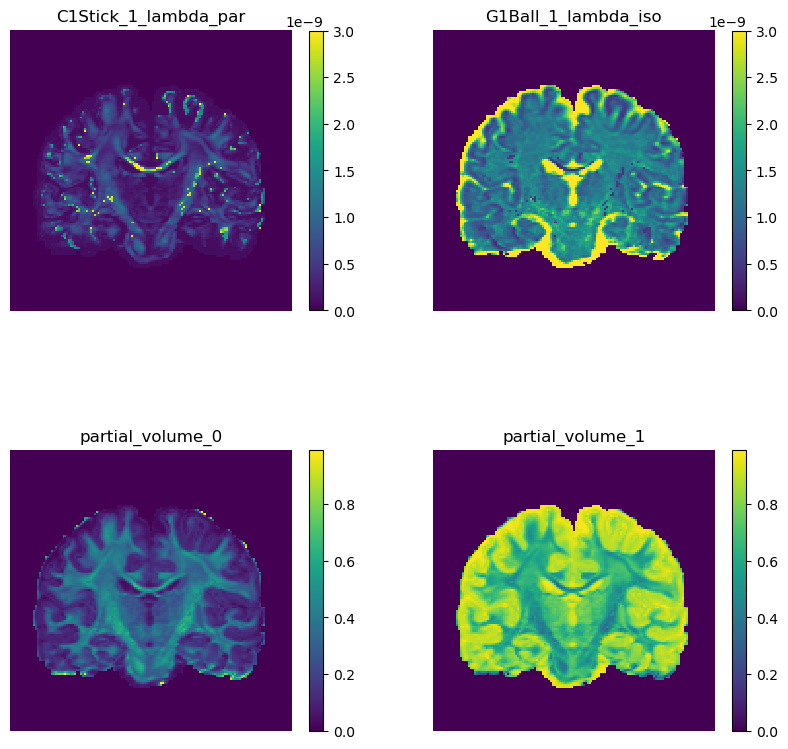

In [24]:
fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin='lower', interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)
    counter += 1

**Simulated Data**

In [16]:
BAS_mod.parameter_ranges

OrderedDict([('C1Stick_1_mu',
              ([0, 3.141592653589793],
               [-3.141592653589793, 3.141592653589793])),
             ('C1Stick_1_lambda_par', (0.1, 3)),
             ('G1Ball_1_lambda_iso', (0.1, 3)),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])

In [17]:
mu = (np.pi / 2., np.pi / 2.)  # in radians (theta, phi)
lambda_par = 1  # in m^2/s
lambda_iso = 2
volume_0 = 0.4
volume_1 = 1-volume_0
BAS_mod_param_vec = BAS_mod.parameters_to_parameter_vector(
    C1Stick_1_lambda_par=lambda_par, C1Stick_1_mu=mu, G1Ball_1_lambda_iso=lambda_iso, partial_volume_0=volume_0, partial_volume_1=volume_1)



In [18]:
BAS_mod_param_vec

array([1.57079633, 1.57079633, 1.        , 2.        , 0.4       ,
       0.6       ])

In [19]:
x0_at_least_2d = np.atleast_2d(BAS_mod_param_vec)
x0_2d = x0_at_least_2d.reshape(-1, x0_at_least_2d.shape[-1])
E_2d = np.empty(np.r_[x0_2d.shape[:-1], scheme_hcp.number_of_measurements])
for i, x0_ in enumerate(x0_2d):
    print(i)
    print(x0_)

0
[1.57079633 1.57079633 1.         2.         0.4        0.6       ]


In [22]:
for item in dir(acq_scheme):

    print(item)
    print(getattr(acq_scheme,item))
    print(getattr(scheme_hcp,item))    

Delta
[0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431
 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431 0.0431


In [ ]:
acq_scheme.gradient_strengths

In [21]:
from dmipy.data import saved_acquisition_schemes


acq_scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

In [68]:
print(acq_scheme.number_of_measurements)

288


In [69]:
print(scheme_hcp.number_of_measurements)

288


In [23]:
E_acq = BAS_mod.simulate_signal(acq_scheme, BAS_mod_param_vec)

In [74]:
E_acq.data.shape

(288,)

In [86]:
data_ = np.atleast_2d(E_acq.data)

In [77]:
mask = data_[..., 0] > 0

In [80]:
mask

array([ True])

In [87]:
print(data_)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [24]:
res_acq = BAS_mod.fit(acq_scheme, E_acq)

Setup brute2fine optimizer in 0.29740095138549805 seconds
Fitting of 1 voxels complete in 0.012503862380981445 seconds.
Average of 0.012503862380981445 seconds per voxel.


In [25]:
print('Optimized result:', res_acq.fitted_parameters_vector)
print('Ground truth:    ', BAS_mod_param_vec)

Optimized result: [[1.45697383e+00 2.32730684e+00 3.00000000e-09 3.00000000e-09
  1.00000000e-02 9.90000000e-01]]
Ground truth:     [1.57079633 1.57079633 1.         2.         0.4        0.6       ]


In [28]:
E_hcp = BAS_mod.simulate_signal(scheme_hcp, BAS_mod_param_vec)

In [81]:
data_ = np.atleast_2d(E_hcp.data)

In [82]:
mask = data_[..., 0] > 0

In [83]:
mask

array([False])

In [84]:
print(data_)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [31]:
res_hcp = BAS_mod.fit(scheme_hcp, E_hcp)

Setup brute2fine optimizer in 0.30399298667907715 seconds
Fitting of 0 voxels complete in 6.198883056640625e-06 seconds.
Average of inf seconds per voxel.


In [52]:
print('Optimized result:', res_hcp.fitted_parameters_vector)
print('Ground truth:    ', BAS_mod_param_vec)

Optimized result: [[0. 0. 0. 0. 0. 0.]]
Ground truth:     [1.57079633 1.57079633 1.         2.         0.4        0.6       ]


In [58]:
acq_scheme.gradient_directions

array([[ 0.519218, -0.678098,  0.520187],
       [ 0.940461, -0.284911, -0.185364],
       [ 0.33274 ,  0.874787,  0.352182],
       [ 0.062696, -0.395116,  0.916489],
       [ 0.195299,  0.895544, -0.399822],
       [ 0.469331, -0.795541, -0.383201],
       [ 0.702082, -0.474367,  0.531089],
       [ 0.277576,  0.337181,  0.899589],
       [-0.636052, -0.084263,  0.767032],
       [ 0.882737,  0.450147,  0.134699],
       [ 0.224295, -0.886244, -0.405294],
       [ 0.201882,  0.12566 ,  0.971315],
       [ 0.843525, -0.420447,  0.334199],
       [-0.448841, -0.255421,  0.85633 ],
       [ 0.972035,  0.234314, -0.015665],
       [ 0.273082,  0.950462, -0.148486],
       [-0.517173,  0.683569, -0.515039],
       [ 0.874913,  0.329195,  0.355188],
       [-0.462356,  0.875544,  0.140178],
       [-0.041258, -0.42121 , -0.906024],
       [-0.785634, -0.078043,  0.613749],
       [ 0.527427, -0.569808,  0.630189],
       [-0.197852, -0.778943,  0.595065],
       [ 0.790547,  0.555951, -0.2

In [59]:
scheme_hcp.gradient_directions

array([[-0.542186,  0.672049, -0.504365],
       [ 0.918106, -0.306174, -0.251672],
       [-0.382921, -0.843687, -0.376249],
       [ 0.097977, -0.442573,  0.891363],
       [ 0.20441 ,  0.907238, -0.367606],
       [-0.420482,  0.790796,  0.444788],
       [-0.713198,  0.520708, -0.469267],
       [ 0.337916,  0.287233,  0.896275],
       [ 0.595529,  0.098477, -0.797274],
       [ 0.902882,  0.417035,  0.104333],
       [ 0.17268 , -0.874402, -0.453434],
       [ 0.258874,  0.07737 ,  0.962807],
       [ 0.84558 , -0.460928,  0.269331],
       [ 0.409899,  0.277682, -0.868835],
       [ 0.976789,  0.205442, -0.060642],
       [ 0.293249,  0.947821, -0.125054],
       [-0.542752,  0.670248, -0.506149],
       [ 0.9029  ,  0.288458,  0.318691],
       [ 0.424887, -0.882829, -0.200209],
       [ 0.104118,  0.382693,  0.91799 ],
       [ 0.754053,  0.081218, -0.651772],
       [ 0.542995, -0.609858,  0.57726 ],
       [ 0.188334,  0.796174, -0.57501 ],
       [ 0.791947,  0.542407, -0.2

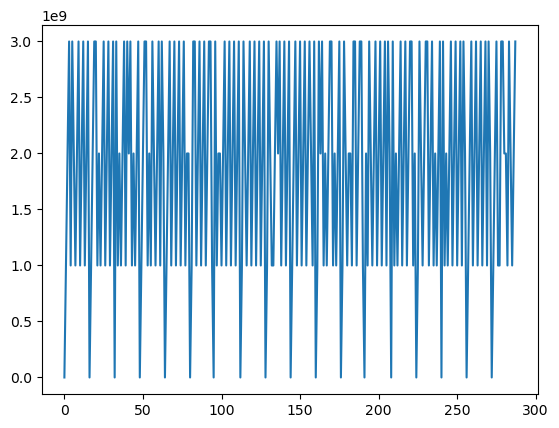

In [56]:
plt.plot(acq_scheme.bvalues)

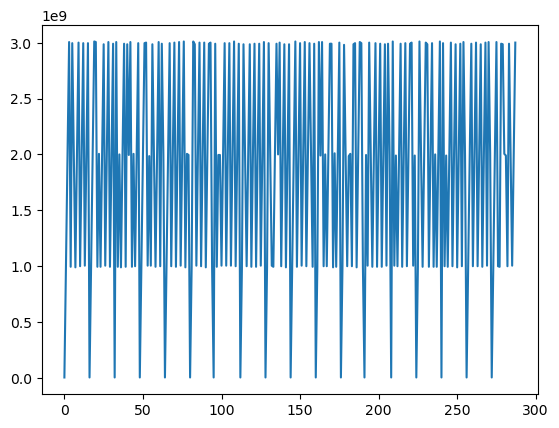

In [57]:
plt.plot(scheme_hcp.bvalues)

In [ ]:
class BallStickNet(nn.Module):
    def __init__(self, ti_no0, gradient_directions_no0, b_values_no0):
        super(BallStickNet, self).__init__()
        self.gradient_directions_no0 = gradient_directions_no0
        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 6))
        
    def forward(self, X):
        params = torch.abs(self.encoder(X))
        t1_ball_uns = params[:, 0]
            t1_ball = squash(t1_ball_uns, 0.010, 5.0)
            t1_stick_uns = params[:, 1]
            t1_stick = squash(t1_stick_uns, 0.010, 5.0)
            lambda_par_uns = params[:, 2]
            lambda_par = squash(lambda_par_uns, 0.1, 3.0)
            lambda_iso_uns = params[:, 3]
            lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
            Fp = params[:,6].unsqueeze(1)
            theta = params[:,4].unsqueeze(1)
            phi = params[:,5].unsqueeze(1)
            mu_cart = torch.zeros(3,X.size()[0])
            sintheta = torch.sin(theta)
            mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
            mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
            mu_cart[2,:] = torch.squeeze(torch.cos(theta))
            if args.s0 == 'yes':
                s0 = params[:,7].unsqueeze(1)
            else: s0 = torch.ones_like(t1_ball)
            mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions_no0, mu_cart)
            X = (Fp*(torch.abs(1 - (2*torch.exp(-self.ti_no0/t1_ball)) + torch.exp(-7.5/t1_ball))*torch.exp(-self.b_values_no0 * lambda_iso)) + (1-Fp)*(torch.abs(1 - (2*torch.exp(-self.ti_no0/t1_stick)) + torch.exp(-7.5/t1_stick))*torch.exp(-self.b_values_no0 * lambda_par * mm_prod ** 2)))*s0
            return X, t1_ball, t1_stick, lambda_par, lambda_iso, mu_cart, Fp, s0


**Simulated Data**

In [22]:
mu = (np.pi / 2., np.pi / 2.)
print(mu)

(1.5707963267948966, 1.5707963267948966)


In [23]:
BAS_mod.parameter_ranges

OrderedDict([('C1Stick_1_mu',
              ([0, 3.141592653589793],
               [-3.141592653589793, 3.141592653589793])),
             ('C1Stick_1_lambda_par', (0.1, 3)),
             ('G1Ball_1_lambda_iso', (0.1, 3)),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])